In [29]:
import numpy as np
import matplotlib.pyplot as plt
from gplearn.genetic import SymbolicClassifier
import pandas as pd
import random
import graphviz
from sklearn.utils import check_random_state
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sympy import *
from IPython.display import display, Math
import os
pd.set_option('display.max_columns', None)


#Dictionary for functions in gplearn
converter = {
    'sub': lambda x, y : x - y,
    'div': lambda x, y : x/y,
    'mul': lambda x, y : x*y,
    'add': lambda x, y : x + y,
    'neg': lambda x    : -x,
    'exp': lambda x, y : x**y,
    'sin': lambda x    : sin(x),
    'cos': lambda x    : cos(x),
    'inv': lambda x: 1/x,
    'sqrt': lambda x: x**0.5,
#     'sq': lambda x: x**2,
    'pow3': lambda x: x**3
}


def multiclass_to_binary(labels, select_id):
    """Converts multiclass labels to select_id vs all
    """
    to_binary = lambda val: 1 if val == select_id else 0
    to_binary_vec = np.vectorize(to_binary)
    labels_1vsall = to_binary_vec(labels)
    return labels_1vsall


def prettify(classifier):
    """Function for prettifying expressions output by the symbolic classifier (denoted as SR_Classifier)
    Converts program expression -> sympy -> latex -> janky matplotlib workaround for latex formulas
    """
    expression = sympify((str(SR_classifier._program)), locals=converter)
    exp_latek = latex(expression)
    ax = plt.axes([0,0,0.3,0.3]) #left,bottom,width,height
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    plt.text(0.8, 0.8,'$%s$'%exp_latek, size=20)
    plt.savefig('../figures/pretty_expression.png',dpi=300,bbox_inches='tight')

## Prep data

In [2]:
### CONSTANTS ###########################################################
label_path = '../3_generate_features/final_label_array.csv'
feat_path = '../3_generate_features/dimensionless_cropped_final_feature_array.csv'
feat_reduction_path = 'features/16_iteration_feature_3_features.csv'
pos_label = 0 
#########################################################################

### Prepare labels
label_df = pd.read_csv(label_path).drop(columns='Unnamed: 0',errors='ignore')
# Find unique labels and counts
class_df = pd.DataFrame(label_df.value_counts()).reset_index()
class_df = class_df.rename(columns={0:'population'})
class_df['label'] = class_df.index
display(class_df.head())
# Convert to numerical labels
proto2label = {proto:label for proto,label in class_df[['Prototype','label']].to_numpy()}
label2proto = {label:proto for proto,label in class_df[['Prototype','label']].to_numpy()}
label_df['label'] = [proto2label[proto] for proto in label_df.Prototype]
label_df.head()
### Define 1vsall version
pos_proto = label2proto[pos_label]
print(f'Predicting {pos_proto} vs. rest')
labels_1vsall = multiclass_to_binary(label_df.label, select_id=pos_label)
print(labels_1vsall)

### Prepare features
feat_df = pd.read_csv(feat_path).drop(columns='Unnamed: 0',errors='ignore')
# display(feat_df.head())
# Reduce features
feature_reduction_df = pd.read_csv(feat_reduction_path)
feature_reduction_feature_names = feature_reduction_df['Name'].to_numpy()
features = feat_df[feature_reduction_feature_names].to_numpy()
feature_names = list(feat_df[feature_reduction_feature_names].columns)

,Prototype,population,label
0,Laves(cub)#MgCu2,1532,0
1,Fluorite#CaF2,507,1
2,Laves(2H)#MgZn2,475,2
3,Rutile#TiO2,467,3
4,AlB2,368,4


Predicting Laves(cub)#MgCu2 vs. rest
[0 0 0 ... 1 0 0]


In [3]:
### Subsampling
###############
#Set rng seed and permutation of data examples for training
rng = check_random_state(5)
# Check number of dominant class examples
n_positive_class = np.sum(labels_1vsall)
# Dominant class boolean index
positive_class_mask = (labels_1vsall == 1)
# Dominant class indexing to grab for training/test set (we want 50/50 representation)
pos_features = features[positive_class_mask,:]
pos_labels = labels_1vsall[positive_class_mask]
# Grabbing all negative examples of which we're going to grab a number equal to the number of dominant class
neg_features = features[~positive_class_mask,:]
neg_labels = labels_1vsall[~positive_class_mask]

# Apply subsampling. We grab a random subset from the negative set of the same size as the positive examples
negative_scrambled_order = rng.permutation(neg_labels.size)
subsample_idx = negative_scrambled_order[:n_positive_class]
# Concatenate an equal amount of negative training data to the list of positive training data so we have 50/50 class representation
# auto-shuffling occurs later in k-fold
features_balanced = np.concatenate((pos_features, neg_features[subsample_idx,:]),axis=0)
labels_balanced = np.concatenate((pos_labels, neg_labels[subsample_idx]), axis=0)
nan_count = np.sum(~np.isfinite(features_balanced))
print(f'{nan_count} NaNs present')

0 NaNs present


In [4]:
### Train-test-split 
####################
#Generate 20-80 splits (we're going to just use one of these for the initial pass)
skf = StratifiedKFold(n_splits=5) 
splits = skf.split(features_balanced, labels_balanced)
# Use first generator output for train/test splits
(train_idx, test_idx) = next(splits)

# Defining train test splits using train/test indices
features_train = features_balanced[train_idx]
features_test =  features_balanced[test_idx]
labels_train = labels_balanced[train_idx]
labels_test =  labels_balanced[test_idx]
print('Train sizes:', len(features_train), len(labels_train))
print('Test sizes: ', len(features_test), len(labels_test))

Train sizes: 2451 2451
Test sizes:  613 613


## Applying Symbolic Regression


In [47]:
### Train sym learner
SR_classifier = SymbolicClassifier(population_size = 2000, generations=100,
                         tournament_size = 100,
                         init_depth=(1,4),
                         parsimony_coefficient=0.006,
                         p_crossover = 0.85,
                         p_subtree_mutation = 0.01,
                         p_point_mutation = 0.01,
                         p_hoist_mutation = 0.1,
                         feature_names=feature_names,
						 random_state=1)

SR_classifier.fit(features_train, labels_train)

SymbolicClassifier(feature_names=['e1_CovalentRadius/e2_CovalentRadius',
                                  '(e1_CovalentRadius+e2_CovalentRadius)/e1_CovalentRadius',
                                  '(e1_Column+e2_Column)/e1_Column'],
                   generations=100, init_depth=(1, 4), p_crossover=0.85,
                   p_hoist_mutation=0.1, parsimony_coefficient=0.006,
                   population_size=2000, random_state=1, tournament_size=100)

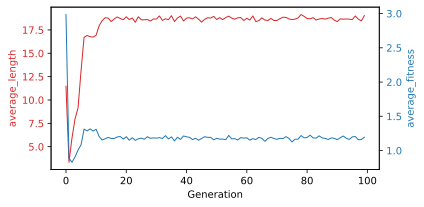

AUC:    	0.7632209235485725
Precision: 	0.7045454545454546
Recall: 	0.9087947882736156
Acc (-):    	0.6379310344827587


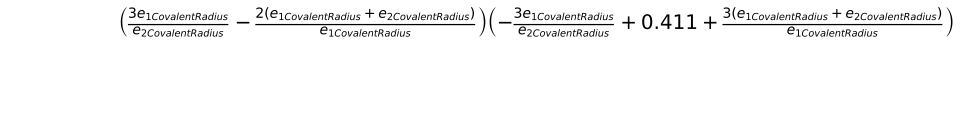

In [48]:
### Plot run history
run_details = SR_classifier.run_details_
fig, ax1 = plt.subplots(figsize=(6,3))
color = 'tab:red'
ax1.set_xlabel('Generation')
ax1.set_ylabel('average_length', color=color)
ax1.plot(run_details['generation'], run_details['average_length'], label='Avg Length', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('average_fitness', color=color)  # we already handled the x-label with ax1
ax2.plot(run_details['generation'], run_details['average_fitness'], label='Avg Length', color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

### Visualize expression
prettify(SR_classifier)

### Evaluate on test set
predictions = SR_classifier.predict(features_test)
precision = precision_score(labels_test, predictions)
recall = recall_score(labels_test, predictions)
roc_auc = roc_auc_score(labels_test,predictions) 
roc_auc
print(f'AUC:    \t{roc_auc}\nPrecision: \t{precision}\nRecall: \t{recall}')

### Evaluate on the rest of the negative class set
# Getting the rest of the negative set features and values
remainder_negative_set_idx = negative_scrambled_order[n_positive_class:]
remainder_negative_features = neg_features[remainder_negative_set_idx,:]
remainder_negative_labels = neg_labels[remainder_negative_set_idx]
acc_neg = np.mean(remainder_negative_labels == SR_classifier.predict(remainder_negative_features))
print(f'Acc (-):    \t{acc_neg}')
# roc_auc = roc_auc_score(remainder_negative_labels,SR_classifier.predict(remainder_negative_features)) 
# print(roc_auc)
# print(f'Prec (- set): \t{precision_score(remainder_negative_labels, SR_classifier.predict(remainder_negative_features))}')

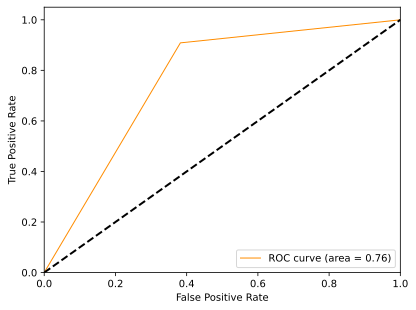

In [49]:
### Plot ROC
fpr, tpr, _ = roc_curve(labels_test,predictions)
plt.figure()
plt.plot( fpr, tpr, color="darkorange", 
         label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="k", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

In [50]:
#Computing estimated probabilities

estimated_classes = SR_classifier.predict_proba(remainder_negative_features)[:,1]

estimated_classes[:20]

array([9.93363042e-03, 2.99762089e-01, 5.93938879e-01, 7.09007917e-01,
       7.40787125e-01, 3.59858286e-01, 2.48228940e-07, 9.93363042e-03,
       6.00594613e-06, 3.42203423e-01, 6.19078925e-01, 3.45796298e-16,
       1.68595737e-03, 2.09959295e-01, 4.81633584e-06, 2.55215056e-47,
       2.24300141e-01, 6.12145737e-01, 5.81097620e-01, 7.35823364e-01])